# @title 1.1. Environment Configuration and Dependencies

In [1]:
# ------------------------------------------------
# Install necessary libraries
# ------------------------------------------------
# This cell installs the required Python packages for the project.
# - tensorflow: The core deep learning framework.
# - scikit-learn: For performance evaluation metrics like classification reports.
# - tf-keras-vis: A library for visualizing and interpreting model predictions (XAI).
# The '-q' flag is used for a quiet installation, reducing the amount of output.

!pip install -q tensorflow scikit-learn tf-keras-vis


--- GPU Verification ---
No GPU detected. The notebook will run on CPU.
--------------------------

--- Dataset Acquisition ---
Found 5 classes: ['Anthracnose', 'BacterialSpot', 'Curl', 'Healthy', 'RingSpot']

--- BDPapayaLeaf Dataset Class Distribution ---
   Class Name  Image Count
  Anthracnose          355
BacterialSpot          458
         Curl          585
      Healthy          228
     RingSpot          533
---------------------------------------------

--- Sample Images ---


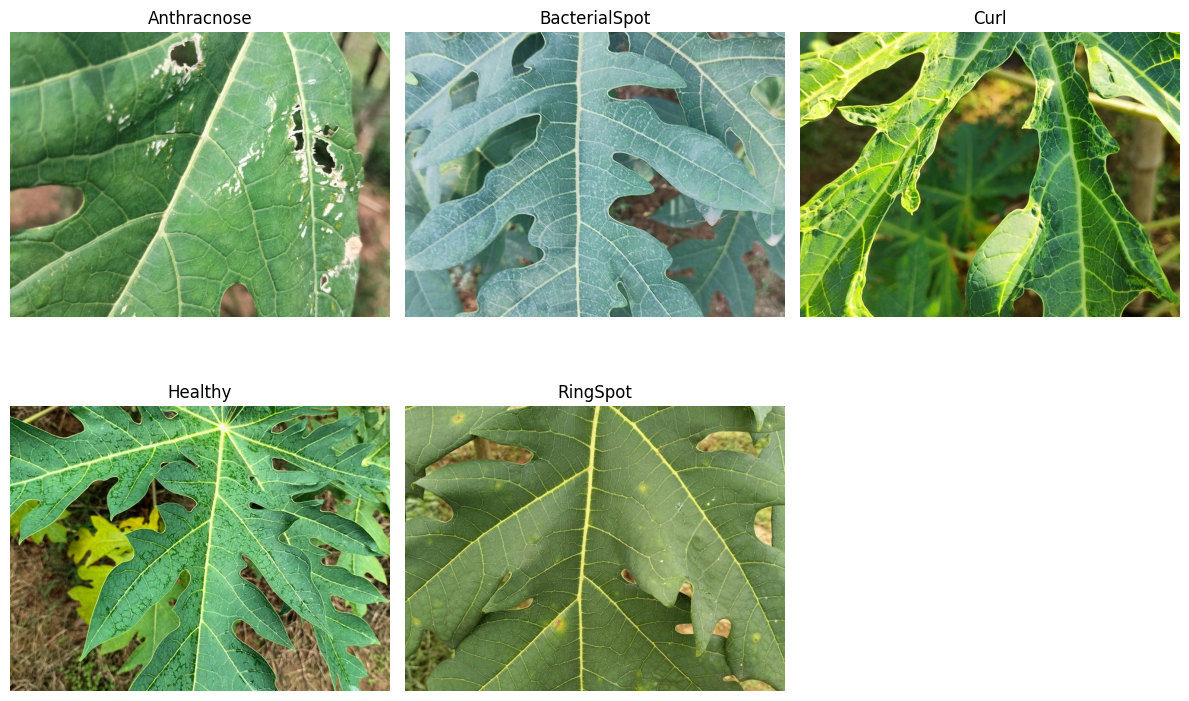

---------------------



In [1]:

# ------------------------------------------------
# Import required modules and set seeds for reproducibility
# ------------------------------------------------
import os
import random
import shutil
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set random seeds to ensure that the results are reproducible across different runs.
# Any operation with a stochastic element (like data shuffling or model weight
# initialization) will produce the same output every time the code is executed.
SEED = 42
os.environ["SEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------------------------------------
# Verify GPU availability
# ------------------------------------------------
# This check confirms if a GPU is available and recognized by TensorFlow.
# Training deep learning models is computationally intensive, and using a GPU
# can accelerate the process by orders of magnitude compared to a CPU.
print("\n--- GPU Verification ---")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use only the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPU Device: {gpus[0].name} is available and configured.")
    except RuntimeError as e:
        print("RuntimeError:", e)
else:
    print("No GPU detected. The notebook will run on CPU.")
print("--------------------------\n")


# @title 1.2. The BDPapayaLeaf Dataset: Acquisition and Profiling
# ------------------------------------------------
# Download and Extract the Dataset
# ------------------------------------------------
# The dataset is downloaded from its Mendeley Data repository using a direct link.
# The 'wget' command fetches the zip archive, and the '-q' flag suppresses download progress output.
# The 'unzip' command extracts the contents into the Colab environment.
print("--- Dataset Acquisition ---")
# ------------------------------------------------
# Profile the Dataset (Exploratory Data Analysis)
# ------------------------------------------------
# The dataset documentation indicates that the images are stored in the
# 'BDPapayaLeaf/Original Images' directory. We will verify this structure
# and count the number of images in each class subdirectory.
original_data_dir = pathlib.Path('BDPapayaLeaf/Original Images')

# List the class names by getting the names of the subdirectories.
class_names = sorted([item.name for item in original_data_dir.glob('*') if item.is_dir()])
print(f"Found {len(class_names)} classes: {class_names}\n")

# Count images per class and store in a dictionary.
image_counts = {class_name: len(list(original_data_dir.glob(f'{class_name}/*.jpg'))) for class_name in class_names}

# Create a pandas DataFrame for a clean, tabular display of the class distribution.
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Class Name', 'Image Count'])
total_images = df_counts['Image Count'].sum()
total_row = pd.DataFrame()
df_counts = pd.concat([df_counts, total_row], ignore_index=True)

print("--- BDPapayaLeaf Dataset Class Distribution ---")
print(df_counts.to_string(index=False))
print("---------------------------------------------\n")

# ------------------------------------------------
# Visualize Sample Images from Each Class
# ------------------------------------------------
# This provides a qualitative look at the dataset, helping to understand the
# visual characteristics and challenges of the classification task.
print("--- Sample Images ---")
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    ax = plt.subplot(2, 3, i + 1)
    # Get the first image from each class directory for display.
    image_path = next((original_data_dir / class_name).glob('*.jpg'))
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()
print("---------------------\n")

In [2]:
# @title 1.3. A Reproducible Data Splitting Protocol
# ------------------------------------------------
# This cell implements a robust, manual data splitting strategy by creating
# separate directories for train, validation, and test sets. This prevents
# data leakage and ensures a fair and reproducible evaluation.
# ------------------------------------------------
print("--- Data Splitting Protocol ---")
split_base_dir = pathlib.Path('papaya_data_split')

# Remove the directory if it already exists to ensure a clean split.
if split_base_dir.exists():
    shutil.rmtree(split_base_dir)
os.makedirs(split_base_dir, exist_ok=True)

# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Create train, validation, and test directories
train_dir = split_base_dir / 'train'
val_dir = split_base_dir / 'validation'
test_dir = split_base_dir / 'test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each class to perform a stratified split
for class_name in class_names:
    print(f"Splitting class: {class_name}")
    # Create class-specific subdirectories in each split folder
    os.makedirs(train_dir / class_name, exist_ok=True)
    os.makedirs(val_dir / class_name, exist_ok=True)
    os.makedirs(test_dir / class_name, exist_ok=True)

    # Get all image file paths for the current class
    class_dir = original_data_dir / class_name
    image_files = list(class_dir.glob('*.jpg'))
    
    # Shuffle the files with a fixed seed for reproducibility
    random.shuffle(image_files)
    
    # Calculate split indices
    n_images = len(image_files)
    train_split_idx = int(n_images * train_ratio)
    val_split_idx = int(n_images * (train_ratio + val_ratio))
    
    # Partition the file list
    train_files = image_files[:train_split_idx]
    val_files = image_files[train_split_idx:val_split_idx]
    test_files = image_files[val_split_idx:]
    
    # Copy files to their new destination directories
    for file in train_files:
        shutil.copy(file, train_dir / class_name)
    for file in val_files:
        shutil.copy(file, val_dir / class_name)
    for file in test_files:
        shutil.copy(file, test_dir / class_name)

print("\nData splitting complete.")
print(f"Total training images: {len(list(train_dir.glob('*/*.jpg')))}")
print(f"Total validation images: {len(list(val_dir.glob('*/*.jpg')))}")
print(f"Total test images: {len(list(test_dir.glob('*/*.jpg')))}")
print("-----------------------------\n")

--- Data Splitting Protocol ---
Splitting class: Anthracnose
Splitting class: BacterialSpot
Splitting class: Curl
Splitting class: Healthy
Splitting class: RingSpot

Data splitting complete.
Total training images: 1509
Total validation images: 324
Total test images: 326
-----------------------------



In [3]:
# @title 1.4. High-Performance Data Ingestion Pipelines
# ------------------------------------------------
# Create tf.data.Dataset objects for each split using a Keras utility.
# This utility automatically infers class labels from the directory structure.
# ------------------------------------------------
print("--- Creating Data Pipelines ---")
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# Create datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    color_mode="rgb"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb"
)

print("Data pipelines created successfully.\n")

# ✅ Save class names BEFORE wrapping
class_names = train_ds.class_names

# Optimize
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Verify
print("--- Pipeline Verification ---")
print(f"Class names inferred by the pipeline: {class_names}")

for image_batch, labels_batch in train_ds.take(1):
    print(f"\nShape of one image batch: {image_batch.shape}")
    print(f"Shape of one label batch: {labels_batch.shape}")
    print(f"Data type of image batch: {image_batch.dtype}")
    print(f"Data type of label batch: {labels_batch.dtype}")

--- Creating Data Pipelines ---
Found 1509 files belonging to 5 classes.
Found 324 files belonging to 5 classes.
Found 326 files belonging to 5 classes.
Data pipelines created successfully.

--- Pipeline Verification ---
Class names inferred by the pipeline: ['Anthracnose', 'BacterialSpot', 'Curl', 'Healthy', 'RingSpot']

Shape of one image batch: (32, 224, 224, 3)
Shape of one label batch: (32, 5)
Data type of image batch: <dtype: 'float32'>
Data type of label batch: <dtype: 'float32'>


In [4]:
print("\n--- Creating Data Pipelines ---")

# --- Constants for Data Loading ---
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Create TensorFlow Dataset objects from the directories
# These act as generators that feed data to the model in batches.

train_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb"
)

val_generator = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb"
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb"
)

print("Data pipelines created successfully.")


# --- Pipeline Verification ---
print("\n--- Pipeline Verification ---")
print(f"Class names inferred by the pipeline: {train_generator.class_names}")

# Let's look at a single batch to verify shapes
for images, labels in train_generator.take(1):
    print(f"Shape of one image batch: {images.shape}")
    print(f"Shape of one label batch: {labels.shape}")
    print(f"Data type of image batch: {images.dtype}")
    print(f"Data type of label batch: {labels.dtype}")


--- Creating Data Pipelines ---
Found 1509 files belonging to 5 classes.
Found 324 files belonging to 5 classes.
Found 326 files belonging to 5 classes.
Data pipelines created successfully.

--- Pipeline Verification ---
Class names inferred by the pipeline: ['Anthracnose', 'BacterialSpot', 'Curl', 'Healthy', 'RingSpot']
Shape of one image batch: (32, 224, 224, 3)
Shape of one label batch: (32, 5)
Data type of image batch: <dtype: 'uint8'>
Data type of label batch: <dtype: 'float32'>


# STEP 3: MODEL ARCHITECTURE DEFINITION & TRANSFER LEARNING

In [5]:
# STEP 3: MODEL ARCHITECTURE DEFINITION & TRANSFER LEARNING
# ==========================================================
print("\n--- Step 3: Model Architecture Definition & Transfer Learning ---")

import tensorflow as tf
from tensorflow.keras.applications import VGG16, EfficientNetB3, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- Constants ---
IMG_SIZE = (224, 224)
NUM_CLASSES = len(class_names)
LEARNING_RATE = 0.0001
EPOCHS = 25 # Increased for potentially better convergence

def build_vgg16_model(num_classes):
    """
    Builds a VGG16 model for transfer learning.

    Args:
        num_classes (int): The number of output classes.

    Returns:
        A compiled Keras Model.
    """
    # Load the VGG16 base model with pre-trained ImageNet weights
    # include_top=False means we don't include the final fully-connected layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

    # Freeze the layers of the base model so they are not updated during the first training phase
    base_model.trainable = False

    # Add a custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout for regularization
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("VGG16 model built successfully.")
    return model

# Instantiate the model
vgg16_model = build_vgg16_model(NUM_CLASSES)

# Display the model architecture
print("\n--- VGG16 Model Summary ---")
vgg16_model.summary()


--- Step 3: Model Architecture Definition & Transfer Learning ---
VGG16 model built successfully.

--- VGG16 Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245,125 (58.16 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


--- Step 4: Model Training (VGG16) ---
Starting training for VGG16 model...
Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.2942 - loss: 5.4902 - val_accuracy: 0.5123 - val_loss: 1.8503
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.4288 - loss: 3.4029 - val_accuracy: 0.6019 - val_loss: 1.5927
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.5215 - loss: 2.6005 - val_accuracy: 0.6173 - val_loss: 1.2862
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.5348 - loss: 2.3067 - val_accuracy: 0.6728 - val_loss: 1.2364
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.5852 - loss: 1.8257 - val_accuracy: 0.6605 - val_loss: 1.0577
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.6070 - loss: 1.6493 - val_accuracy: 0.7006 - val_loss: 1.0118
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.6335 - loss: 1.4242 - val_accuracy: 0.6636 - val_loss: 0.9134
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━

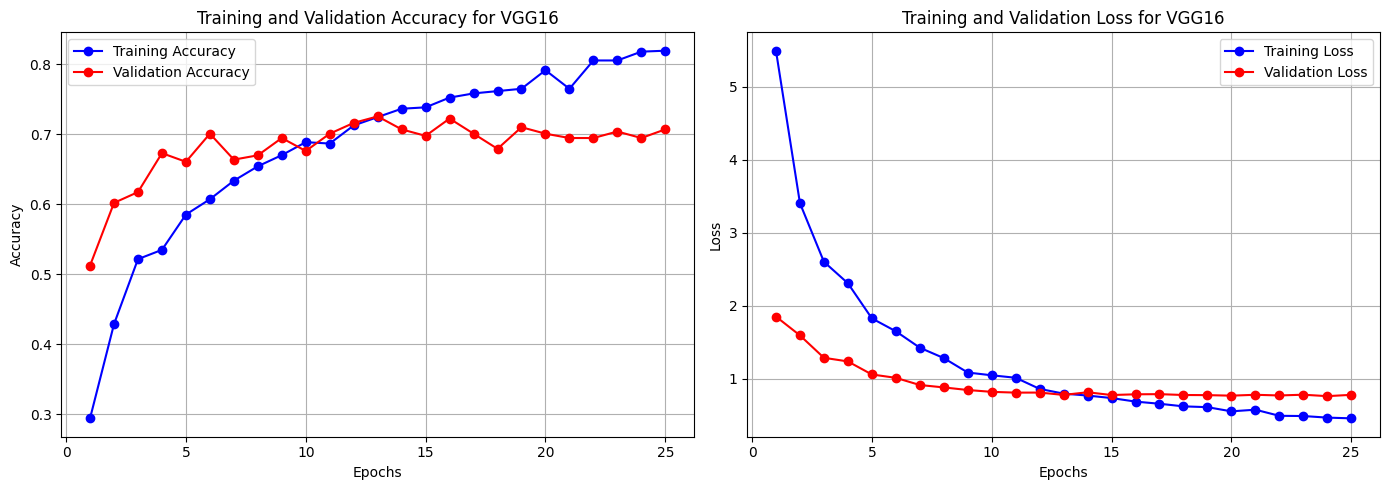

In [6]:
# STEP 4: MODEL TRAINING
# ======================
print("\n--- Step 4: Model Training (VGG16) ---")

# We will use EarlyStopping to prevent overfitting. It stops training when the
# validation loss has not improved for a certain number of epochs ('patience').
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True # Restores model weights from the epoch with the best value
)

print("Starting training for VGG16 model...")
# Note: Since no GPU is detected, this will be slow.
# For a full run, 25 epochs might take a significant amount of time.
# You can reduce EPOCHS for a quick test.

history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

vgg16_model.save("vgg16.keras")

print("VGG16 model training complete.")

# --- Visualize Training History ---
def plot_history(history, model_name):
    """
    Plots the training and validation accuracy and loss.

    Args:
        history: The training history object from model.fit().
        model_name (str): Name of the model for titles.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)


    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("\n--- Visualizing VGG16 Training History ---")
plot_history(history_vgg16, "VGG16")



--- Step 5: Model Evaluation (VGG16) ---
Making predictions on the test data...
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
Extracting true labels...

--- Classification Report for VGG16 ---
               precision    recall  f1-score   support

  Anthracnose       0.80      0.67      0.73        54
BacterialSpot       0.44      0.45      0.45        69
         Curl       0.63      0.62      0.63        88
      Healthy       0.86      0.86      0.86        35
     RingSpot       0.78      0.86      0.82        80

     accuracy                           0.68       326
    macro avg       0.70      0.69      0.70       326
 weighted avg       0.68      0.68      0.68       326


--- Generating Confusion Matrix for VGG16 ---


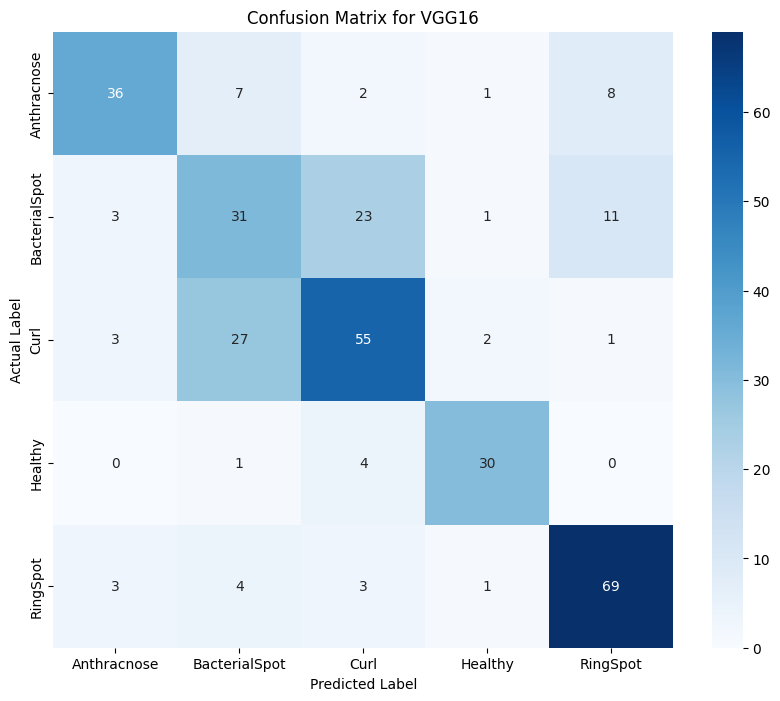

In [7]:
# STEP 5: MODEL EVALUATION (VGG16)
# ==================================
# This code should be run after the code for Step 4 (Model Training)

print("\n--- Step 5: Model Evaluation (VGG16) ---")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Ensure we have the necessary variables from the previous steps
# vgg16_model, test_generator, class_names

# 1. Make predictions on the test set
print("Making predictions on the test data...")
y_pred_probs = vgg16_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 2. Get the true labels from the test generator
print("Extracting true labels...")
y_true_labels = []
# We need to iterate through the generator to get all true labels
for images, labels in test_generator:
  y_true_labels.extend(np.argmax(labels.numpy(), axis=1))

y_true_labels = np.array(y_true_labels)


# 3. Generate and print the Classification Report
print("\n--- Classification Report for VGG16 ---")
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print(report)


# 4. Generate and plot the Confusion Matrix
print("\n--- Generating Confusion Matrix for VGG16 ---")
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for VGG16')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot the matrix
plot_confusion_matrix(y_true_labels, y_pred_labels, class_names)

In [4]:
from tensorflow.keras import backend as K
K.clear_session()

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
from tensorflow.keras.applications.efficientnet import preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

In [13]:
# STEPS 3, 4, 5 for EfficientNetB3 (Final Attempt with Sequential API)
# =====================================================================
# This version uses a different model construction API (Sequential) to
# bypass the persistent bug in the model's constructor.

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Clear Session ---
tf.keras.backend.clear_session()
print("Keras backend session cleared.")

# --- Constants ---
IMG_SIZE_EFFICIENTNET = (300, 300)
BATCH_SIZE = 16
NUM_CLASSES = len(class_names)
LEARNING_RATE = 0.0001
EPOCHS = 25

# --- Recreate Data Pipelines (if needed after a restart) ---
print("Creating data pipelines for EfficientNetB3 (300x300)...")
train_generator_eff = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE_EFFICIENTNET, batch_size=BATCH_SIZE,
    label_mode='categorical', shuffle=True
)
val_generator_eff = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE_EFFICIENTNET, batch_size=BATCH_SIZE,
    label_mode='categorical', shuffle=False
)
test_generator_eff = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE_EFFICIENTNET, batch_size=BATCH_SIZE,
    label_mode='categorical', shuffle=False
)
print("Pipelines created.")


# --- Step 3: Build Model with Sequential API ---
# Create the base model
base_model = EfficientNetB3(weights='imagenet', include_top=False,
                            input_shape=IMG_SIZE_EFFICIENTNET + (3,))
# Freeze the base model
base_model.trainable = False

# Assemble the model sequentially
sequential_model = Sequential([
    # The Input layer explicitly defines the entry point
    Input(shape=IMG_SIZE_EFFICIENTNET + (3,)),
    # Add the pre-trained base model
    base_model,
    # Add the classification head
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
sequential_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                         loss='categorical_crossentropy', metrics=['accuracy'])

print("\n--- Model Summary (Sequential API) ---")
sequential_model.summary()


# --- Step 4 & 5: Training and Evaluation ---
print("\n--- Starting Training (Sequential Model)... ---")
history_seq = sequential_model.fit(
    train_generator_eff, epochs=EPOCHS, validation_data=val_generator_eff,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

print("\n--- Evaluating Sequential Model ---")
plot_history(history_seq, "EfficientNetB3 (Sequential)")
y_pred_probs = sequential_model.predict(test_generator_eff)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.concatenate([y for x, y in test_generator_eff], axis=0)
y_true_labels = np.argmax(y_true_labels, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

print("\n--- Confusion Matrix ---")
plot_confusion_matrix(y_true_labels, y_pred_labels, class_names)

Keras backend session cleared.
Creating data pipelines for EfficientNetB3 (300x300)...
Found 1509 files belonging to 5 classes.
Found 324 files belonging to 5 classes.
Found 326 files belonging to 5 classes.
Pipelines created.


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 40). Received saved weight with shape (3, 3, 3, 40)